# This notebook explores RT model data for absorption retrievals.

## Author:  g.mahapatra@tudelft.nl



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Add the file path containing the results for various models.

In [5]:
path = '/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/modelresults1/'

# load the aerosols.in file used to create the models.
aerosols = np.loadtxt(path+'aerosols.in')
print('Shape of aerosols:',aerosols.shape)

# load the wavelength points 
wav = np.load(path+'wav.npy')
print('Wavelengths(microns):',wav)

# load the geometries file
geom = np.loadtxt(path+'geos.in',skiprows=4)
print('Shape of Geometries:',geom.shape)
#print(geom)
geomdf = pd.DataFrame(geom,columns=['alpha','theta0','theta','phi','beta'])

# make a dataframe to view the data
columns = ['ScaleHeightModel','CloudWidth(km)','CloudScaleHeight(km)','CloudTopAltitude(km)','CloudOpacity','HazeScaleHeight(km)','HazeOpacity','ProfileNum']
aerosolsdf = pd.DataFrame(aerosols,columns=columns)
aerosolsdf
#geom.head(10)

Shape of aerosols: (105, 8)
Wavelengths(microns): [1.4   1.425 1.435 1.44  1.445 1.455]
Shape of Geometries: (91, 5)


,ScaleHeightModel,CloudWidth(km),CloudScaleHeight(km),CloudTopAltitude(km),CloudOpacity,HazeScaleHeight(km),HazeOpacity,ProfileNum
0,1.0,0.0,2.0,60.0,30.0,4.0,0.1,1.0
1,1.0,0.0,2.0,61.0,30.0,4.0,0.1,2.0
2,1.0,0.0,2.0,62.0,30.0,4.0,0.1,3.0
3,1.0,0.0,2.0,63.0,30.0,4.0,0.1,4.0
4,1.0,0.0,2.0,64.0,30.0,4.0,0.1,5.0
...,...,...,...,...,...,...,...,...
100,1.0,0.0,6.0,76.0,30.0,4.0,0.1,102.0
101,1.0,0.0,6.0,77.0,30.0,4.0,0.1,103.0
102,1.0,0.0,6.0,78.0,30.0,4.0,0.1,104.0
103,1.0,0.0,6.0,79.0,30.0,4.0,0.1,105.0


### Add the file path containing the results for various models.

Make a loop over all the models and gather them into one array. 

In [6]:
# make an empty list
results = []
for i in range(len(aerosols)):
    try:
        results.append(np.load(path+'kspectra_{:05d}.npy'.format(i)))
    except:
        pass # donothing
# convert into an array 
results = np.array(results)

## Print the shape. The shape should be: 
     [no.of models,no.of geometries,Stokes(I Q U),lambda]

In [7]:
print('Shape =',results.shape)
results[0,0,0,0]

Shape = (105, 91, 3, 6)


0.8407859407433664

## Make a dataframe containing all the data

In [8]:
# flatten the array
results_flat = []
for i in range(len(results[:,0,0,0])):
    for j in range(len(results[0,:,0,0])):
        for k in range(len(results[0,0,0,:])):
            results_flat.append([i+1,j,wav[k],results[i,j,0,k],results[i,j,1,k],results[i,j,2,k]])
# convert into array
results_flat = np.array(results_flat)
# convert into DataFrame
df = pd.DataFrame(results_flat,columns=['ModelNum','GeomNum','Lambda','F','Q','U'])

# add the degree of polarization column
df['P'] = -df['Q']/df['F']

# modify the lambda into nanometers
df['Lambda'] = np.round(df['Lambda']*1e3)
# convert into int type
df['Lambda'] = df['Lambda'].astype(int)

print('Shape of data:',df.shape)
df.head(100)


Shape of data: (57330, 7)


,ModelNum,GeomNum,Lambda,F,Q,U,P
0,1.0,0.0,1400,0.840786,0.000000,0.0,-0.000000
1,1.0,0.0,1425,0.834154,0.000000,0.0,-0.000000
2,1.0,0.0,1435,0.826738,0.000000,0.0,-0.000000
3,1.0,0.0,1440,0.817418,0.000000,0.0,-0.000000
4,1.0,0.0,1445,0.805137,0.000000,0.0,-0.000000
...,...,...,...,...,...,...,...
95,1.0,15.0,1455,0.781039,0.009235,0.0,-0.011824
96,1.0,16.0,1400,0.833017,0.010291,0.0,-0.012354
97,1.0,16.0,1425,0.826301,0.009989,0.0,-0.012089
98,1.0,16.0,1435,0.818952,0.009866,0.0,-0.012047


In [9]:
## Merge the aerosol data into the dataframe
df = pd.merge(df,aerosolsdf,left_on=['ModelNum'],right_on=['ProfileNum'],how='left')
# drop the profileNum column
df = df.drop('ProfileNum',axis=1)
df = df.drop(['ScaleHeightModel','CloudWidth(km)'],axis=1)

# Merge the geometry data into the dataframe
df = pd.merge(df,geomdf,left_on=['GeomNum'],right_on=['theta0'],how='left')

# rename some of the columns for convenience
df = df.rename(columns={'CloudScaleHeight(km)':'CSH(km)','CloudTopAltitude(km)':'CTA(km)','CloudOpacity':'CO',
                   'HazeScaleHeight(km)':'HSH(km)','HazeOpacity':'HO'})

df.head(100)

,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),CO,HSH(km),HO,alpha,theta0,theta,phi,beta
0,1.0,0.0,1400,0.840786,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1425,0.834154,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1435,0.826738,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1440,0.817418,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1445,0.805137,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,15.0,1455,0.781039,0.009235,0.0,-0.011824,2.0,60.0,30.0,4.0,0.1,15.0,15.0,0.0,0.0,0.0
96,1.0,16.0,1400,0.833017,0.010291,0.0,-0.012354,2.0,60.0,30.0,4.0,0.1,16.0,16.0,0.0,0.0,0.0
97,1.0,16.0,1425,0.826301,0.009989,0.0,-0.012089,2.0,60.0,30.0,4.0,0.1,16.0,16.0,0.0,0.0,0.0
98,1.0,16.0,1435,0.818952,0.009866,0.0,-0.012047,2.0,60.0,30.0,4.0,0.1,16.0,16.0,0.0,0.0,0.0


## Here we start the exploration

(91, 3, 85)


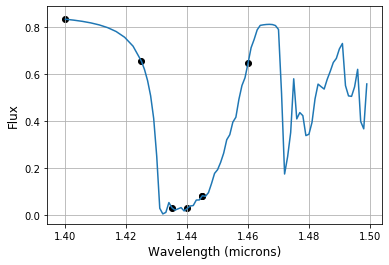

In [10]:
# visualize the wavelengths chosen, on the absorption spectra 
kspectra = np.load('/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsCode/fullKDIS/results/all_models_paper/kspectra_00008.npy')
wav0 = np.load('/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsCode/fullKDIS/results/all_models_paper/wav.npy')
print(kspectra.shape)
plt.plot(wav0,kspectra[30,0,:])
plt.scatter(wav0[0],kspectra[30,0,0],c='k')
plt.scatter(wav0[9],kspectra[30,0,9],c='k')
plt.scatter(wav0[20],kspectra[30,0,20],c='k')
plt.scatter(wav0[25],kspectra[30,0,25],c='k')
plt.scatter(wav0[30],kspectra[30,0,30],c='k')
plt.scatter(wav0[30],kspectra[30,0,30],c='k')
plt.scatter(wav0[45],kspectra[30,0,45],c='k')
plt.xlabel('Wavelength (microns)',fontsize='large')
plt.ylabel('Flux',fontsize='large')
plt.grid()
#print(wav0)

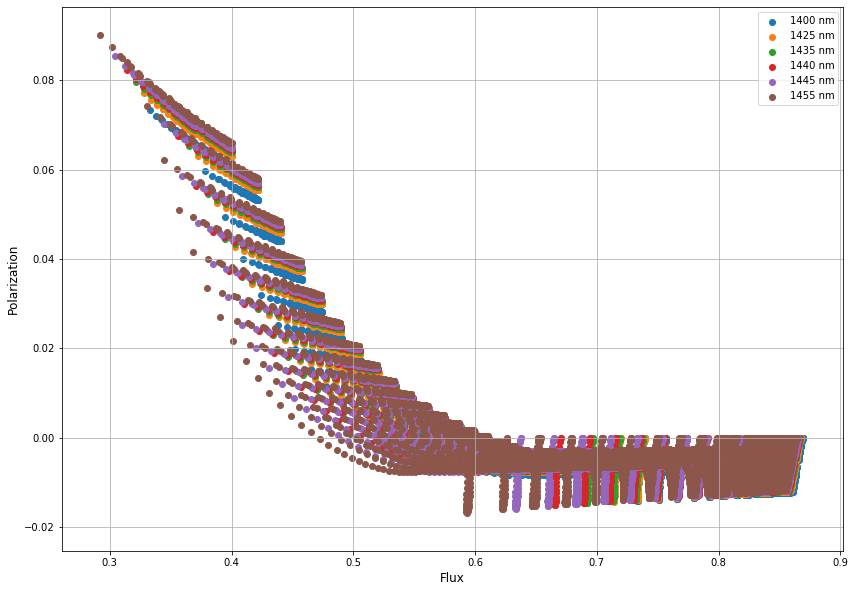

In [11]:
plt.figure(figsize=[14,10])
plt.scatter(df[df['Lambda']==1400]['F'],df[df['Lambda']==1400]['P'],label='1400 nm')
plt.scatter(df[df['Lambda']==1425]['F'],df[df['Lambda']==1425]['P'],label='1425 nm')
plt.scatter(df[df['Lambda']==1435]['F'],df[df['Lambda']==1435]['P'],label='1435 nm')
plt.scatter(df[df['Lambda']==1440]['F'],df[df['Lambda']==1440]['P'],label='1440 nm')
plt.scatter(df[df['Lambda']==1445]['F'],df[df['Lambda']==1445]['P'],label='1445 nm')
plt.scatter(df[df['Lambda']==1455]['F'],df[df['Lambda']==1455]['P'],label='1455 nm')
plt.xlabel('Flux',fontsize='large')
plt.ylabel('Polarization',fontsize='large')
plt.legend()
plt.grid()

In [12]:
# visulaise the dataset with cloud top variation
df[(df['CTA(km)']==65.0)&(df['theta0']==60)]

,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),CO,HSH(km),HO,alpha,theta0,theta,phi,beta
3090,6.0,60.0,1400,0.736775,0.005720,0.0,-0.007764,2.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
3091,6.0,60.0,1425,0.734680,0.005176,0.0,-0.007045,2.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
3092,6.0,60.0,1435,0.732705,0.004957,0.0,-0.006765,2.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
3093,6.0,60.0,1440,0.730304,0.004847,0.0,-0.006636,2.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
3094,6.0,60.0,1445,0.727068,0.004736,0.0,-0.006514,2.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
3095,6.0,60.0,1455,0.722282,0.004515,0.0,-0.006251,2.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
14556,27.0,60.0,1400,0.732073,0.005705,0.0,-0.007792,3.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
14557,27.0,60.0,1425,0.729189,0.005161,0.0,-0.007078,3.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
14558,27.0,60.0,1435,0.726190,0.004942,0.0,-0.006805,3.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
14559,27.0,60.0,1440,0.722443,0.004831,0.0,-0.006687,3.0,65.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0


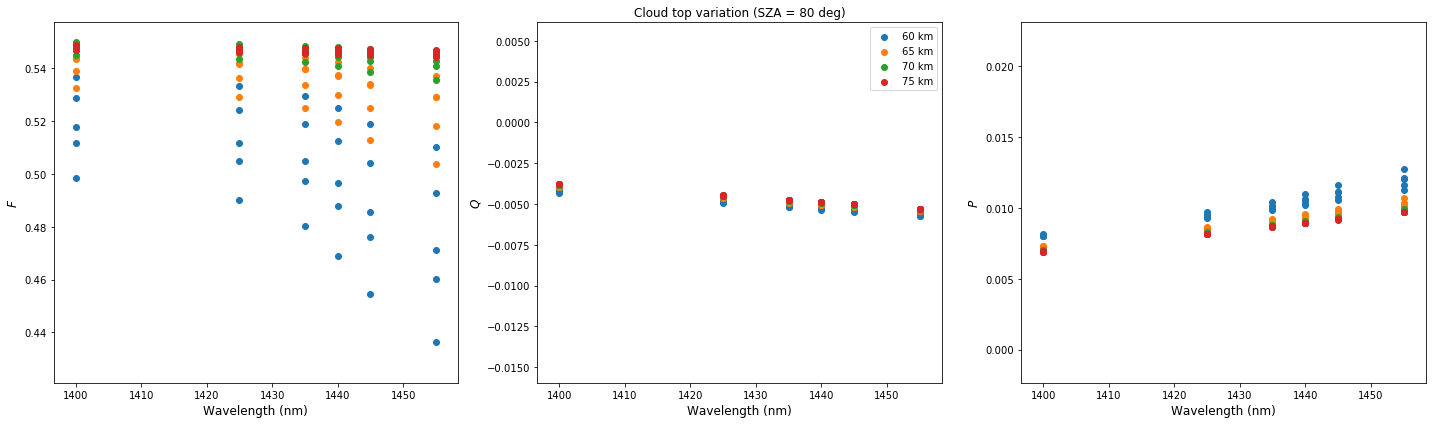

In [13]:
# plot all the wavelength data at specific cloud tops 
%matplotlib inline
sza = 80
plt.figure(figsize=[20,6])
plt.subplot(131)
idx = (df['CTA(km)']==60.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['F'],label='60 km')
idx = (df['CTA(km)']==65.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['F'],label='65 km')
idx = (df['CTA(km)']==70.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['F'],label='70 km')
idx = (df['CTA(km)']==75.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['F'],label='75 km')
plt.xlabel('Wavelength (nm)',fontsize='large')
plt.ylabel('$F$',fontsize='large')

plt.subplot(132)
plt.title('Cloud top variation (SZA = {:02d} deg)'.format(sza))
idx = (df['CTA(km)']==60.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['Q'],label='60 km')
idx = (df['CTA(km)']==65.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['Q'],label='65 km')
idx = (df['CTA(km)']==70.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['Q'],label='70 km')
idx = (df['CTA(km)']==75.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['Q'],label='75 km')
#plt.ylim([0.004,0.0055])
plt.legend()
plt.xlabel('Wavelength (nm)',fontsize='large')
plt.ylabel('$Q$',fontsize='large')

plt.subplot(133)
idx = (df['CTA(km)']==60.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['P'],label='60 km')
idx = (df['CTA(km)']==65.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['P'],label='65 km')
idx = (df['CTA(km)']==70.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['P'],label='70 km')
idx = (df['CTA(km)']==75.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['P'],label='75 km')
#plt.ylim([-0.0075,-0.005])
plt.xlabel('Wavelength (nm)',fontsize='large')
plt.ylabel('$P$',fontsize='large')
#plt.show()
plt.tight_layout()

In [14]:
# visulaise the dataset with cloud scale height variation
df[(df['CSH(km)']==4.0)&(df['theta0']==60)]

,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),CO,HSH(km),HO,alpha,theta0,theta,phi,beta
23292,43.0,60.0,1400,0.692073,0.005476,0.0,-0.007912,4.0,60.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
23293,43.0,60.0,1425,0.683148,0.004942,0.0,-0.007234,4.0,60.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
23294,43.0,60.0,1435,0.672710,0.004721,0.0,-0.007018,4.0,60.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
23295,43.0,60.0,1440,0.659762,0.004603,0.0,-0.006976,4.0,60.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
23296,43.0,60.0,1445,0.643264,0.004480,0.0,-0.006964,4.0,60.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34759,64.0,60.0,1425,0.660579,0.004926,0.0,-0.007458,4.0,80.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
34760,64.0,60.0,1435,0.647169,0.004704,0.0,-0.007269,4.0,80.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
34761,64.0,60.0,1440,0.630771,0.004584,0.0,-0.007267,4.0,80.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0
34762,64.0,60.0,1445,0.610295,0.004457,0.0,-0.007304,4.0,80.0,30.0,4.0,0.1,60.0,60.0,0.0,0.0,0.0


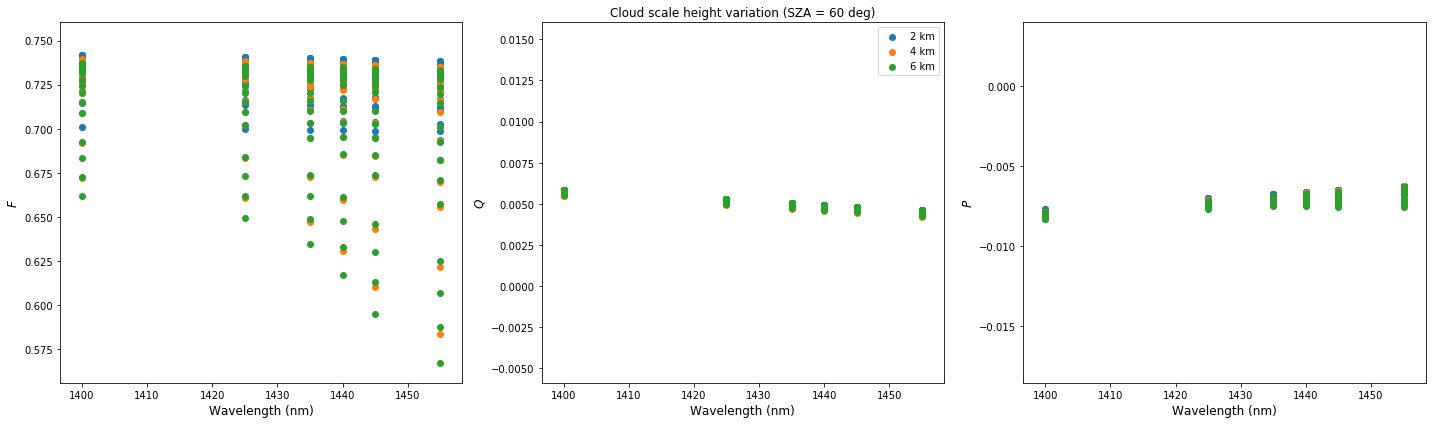

In [15]:
# plot all the wavelength data at specific cloud scale heights 
%matplotlib inline
sza = 60
plt.figure(figsize=[20,6])
plt.subplot(131)
idx = (df['CSH(km)']==2.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['F'],label='2 km')
idx = (df['CSH(km)']==4.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['F'],label='4 km')
idx = (df['CSH(km)']==6.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['F'],label='6 km')
plt.xlabel('Wavelength (nm)',fontsize='large')
plt.ylabel('$F$',fontsize='large')

plt.subplot(132)
plt.title('Cloud scale height variation (SZA = {:02d} deg)'.format(sza))
idx = (df['CSH(km)']==2.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['Q'],label='2 km')
idx = (df['CSH(km)']==4.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['Q'],label='4 km')
idx = (df['CSH(km)']==6.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['Q'],label='6 km')
#plt.ylim([0.004,0.0055])
plt.legend()
plt.xlabel('Wavelength (nm)',fontsize='large')
plt.ylabel('$Q$',fontsize='large')

plt.subplot(133)
idx = (df['CSH(km)']==2.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['P'],label='2 km')
idx = (df['CSH(km)']==4.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['P'],label='4 km')
idx = (df['CSH(km)']==6.0)&(df['theta0']==sza)
plt.scatter(df[idx]['Lambda'],df[idx]['P'],label='6 km')
#plt.ylim([-0.0075,-0.005])
plt.xlabel('Wavelength (nm)',fontsize='large')
plt.ylabel('$P$',fontsize='large')
#plt.show()
plt.tight_layout()